In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))

In [2]:
import os
import sys
sys.path.append('../')

In [3]:
from model import UnicycleModel
from cost import UnicycleCost
from constraints import UnicycleConstraints
from scipy.integrate import solve_ivp
from matplotlib.patches import Ellipse
from utils.utils_alg import get_neighbor_vec,get_K_discrete
from utils.utils_plot import plot_traj,plot_traj_set,plot_state_input
from Single_PTR import Single_PTR
from utils.utils_alg import get_sample_eta_w,propagate_model
import cvxpy as cvx
from scipy.integrate import solve_ivp
from EstimatingLipschitz import Lipschitz
from LMI import Q_update

In [4]:
ix = 3
iu = 2
iw = 2
iq = 2
ip = 2
N = 30
tf = 3
delT = tf/N

In [5]:
# time-invariant matrices
C = np.array([[0,0,1],[0,0,0]])
D = np.array([[0,0],[1,0]])
E = np.array([[1,0],[0,1],[0,0]])
G = np.zeros((iq,iw))

## obstacle setting

In [6]:
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])
# obstacle
c_list = []
H_list = []
c1 = [1,2]
H1 = get_H_obs(0.75,1.5)
c_list.append(c1)
H_list.append(H1)
c2 = [4,3]
H2 = get_H_obs(0.75,1.5)
c_list.append(c2)
H_list.append(H2)

## initial and final conditions 

In [7]:
xi = np.zeros(3)
xi[0] = 0.0
xi[1] = 0.0 
xi[2] = 0

xf = np.zeros(3)
xf[0] = 5.0
xf[1] = 5.0
xf[2] = 0

Qini = np.diag([0.4**2,0.4**2,np.deg2rad(20)**2])
# Qf = np.diag([0.3**2,0.3**2,np.deg2rad(10)**2])
Qf = np.diag([0.5**2,0.5**2,np.deg2rad(20)**2])*1.5



myModel = UnicycleModel.unicycle('Hello',ix,iu,iw,'numeric_central')
myCost = UnicycleCost.unicycle('Hello',ix,iu,N)
myConst = UnicycleConstraints.UnicycleConstraints('Hello',ix,iu)
myConst.set_obstacle(c_list,H_list)

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf
u0 = np.zeros((N+1,iu))

A,B,s,z,x_prop_n = myModel.diff_discrete_zoh(x0[0:N,:],u0[0:N,:],delT,tf) 
S = np.eye(ix)
R = 2*np.eye(iu)
K0 = get_K_discrete(A,B,S,R,S,N,ix,iu)
Q0 = np.tile(np.diag([0.35**2,0.35**2,np.deg2rad(10)**2]),(N+1,1,1))
Y0 = K0@Q0[:N]
betahat = np.ones(N+1)

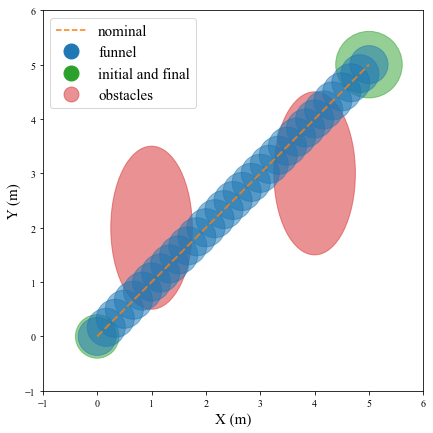

In [19]:
plt.figure(1,figsize=(7,7))
plot_traj_set(x0,u0,c_list,H_list,Q0,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt)
plt.rcParams["font.family"] = "Times New Roman"
plt.savefig('../images/first_iteration/initial.pdf')
# plt.close()

## choose sample points

In [9]:
num_sample = 100
zs_sample = [] # sample in unit sphere will be projected to ellipse (Q_k)
zw_sample = [] 
    
# uniformly fixed
for i in np.linspace(-1.0, 1.0, num=5) :
    for j in np.linspace(-1.0, 1.0, num=5) :
        for k in np.linspace(-1.0, 1.0, num=4) :
            z = np.array([i,j,k])
            zs = z / np.linalg.norm(z)
            zs_sample.append(zs)
for i in np.linspace(-1.0, 1.0, num=10) :
    for j in np.linspace(-1.0, 1.0, num=10) :
        z = np.array([i,j])
        zw = z / np.linalg.norm(z)
        zw_sample.append(zw)

## step 1 : Nominal trajectory update (Single PTR)

In [10]:
xhat,uhat,Qhat,Yhat,Khat = x0,u0,Q0,Y0,K0

In [11]:
print("STEP 1 : Nominal trajectory update")
traj_solver= Single_PTR('unicycle',N,tf,1,myModel,myCost,myConst,
          w_c=1,w_vc=1e3,w_tr=1e1,tol_vc=1e-6,tol_tr=1e-4,verbosity=False)
_,_,xnew,unew,total_num_iter,flag_boundary,traj_cost,traj_vc,traj_tr = traj_solver.run(xhat,uhat,xi,xf,Qhat,Khat)


STEP 1 : Nominal trajectory update


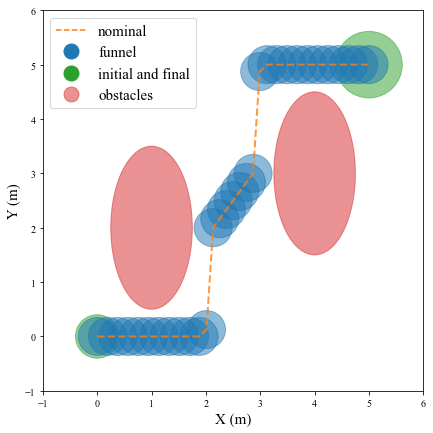

In [12]:
plt.figure(0,figsize=(7,7))
plot_traj_set(xnew,unew,c_list,H_list,Qhat,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt)
plt.rcParams["font.family"] = "Times New Roman"
plt.savefig('../images/first_iteration/traj_update.pdf')

## Discretization

In [13]:
# discretization
A,B,F,s,z,x_prop_n = myModel.diff_discrete_zoh_noise(xnew,unew,np.zeros((N,iw)),delT,tf) 
sz = tf*s + z
# propagation
xprop,_ = traj_solver.forward_multiple(xnew,unew)
e_prop = np.linalg.norm(xprop - xnew[1:],axis=1)

## step 2 : Estimating $\gamma$

In [14]:
print("STEP 2 : Lipschitz constant estimation")
myM = Lipschitz(ix,iu,iq,ip,iw,N)
myM.initialize(xnew,unew,xprop,Qhat,Khat,A,B,C,D,E,F,G,myModel,zs_sample,zw_sample)
gamma = myM.update_lipschitz_norm(myModel,delT)
gamma = myM.update_lipschitz_parallel(myModel,delT)
print("mean of gamma",np.mean(gamma,0),"max of gamma",np.max(gamma,0),"var of gamma",np.var(gamma,0))

STEP 2 : Lipschitz constant estimation
mean of gamma 0.015398942925700933 max of gamma 0.01756890370169187 var of gamma 5.9682050556865584e-06


## step 3 : Funnel update

In [15]:
print("STEP 3 : Funnel update via SDP")
funl_solver = Q_update(ix,iu,iq,ip,iw,N,delT,myCost.S,myCost.R,w_tr=1e1)
funl_solver.initialize(xnew,unew,e_prop*0,A,B,C,D,E,F,G)
alpha = 0.99
Qnew,Knew,Ynew,status,funl_cost = funl_solver.solve(alpha,gamma,Qini,Qf,Qhat,Yhat)
print("LMI status:" + status)

STEP 3 : Funnel update via SDP
LMI status:optimal


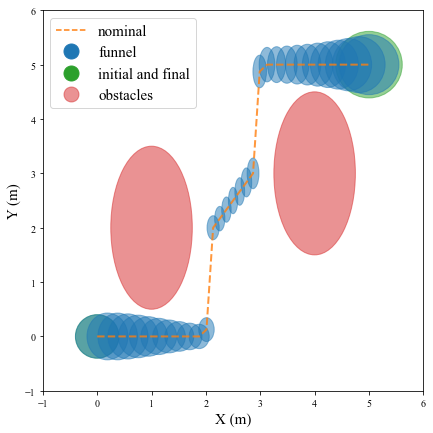

In [16]:
plt.figure(0,figsize=(7,7))
plot_traj_set(xnew,unew,c_list,H_list,Qnew,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt)
plt.rcParams["font.family"] = "Times New Roman"
plt.savefig('../images/first_iteration/funnel_update.pdf')

In [17]:
print("STEP 4 : update beta for invariance")
betanew = funl_solver.update_beta(Qnew,Knew,gamma,alpha)
for i in range(N+1) :
    Qnew[i] = Qnew[i] * betanew[i]
print("beta max {:}".format(np.max(betanew)))

STEP 4 : update beta for invariance
beta max 1.0


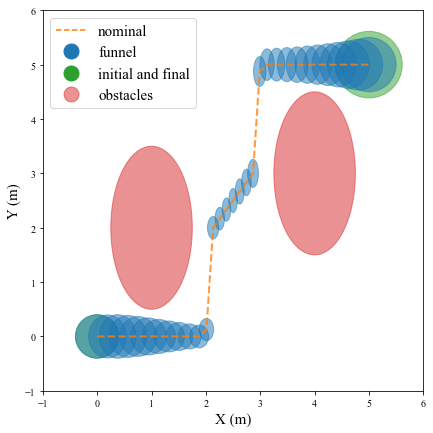

In [18]:
# plot the trajectory
plt.figure(0,figsize=(7,7))
plot_traj_set(xnew,unew,c_list,H_list,Qnew,xi=xi,xf=xf,Qi=Qini,Qf=Qf,plt=plt)
plt.rcParams["font.family"] = "Times New Roman"
plt.savefig('../images/first_iteration/beta_update.pdf')